# Code used for **Finnaly! Understanding what PCA really means in finance** newsletter

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.decomposition import PCA

### 4- Methodology

**1. DATA PREPARATION:**

- Data Cleaning and Calculation of Logarithmic Returns
  
- Data Splitting

- Normalizing Returns



In [2]:
#Download prices from github
filepath ='https://raw.githubusercontent.com/alfonso-santos/Understanding-PCA-in-finance/main/data/preciosSP500.csv'

prices_sp500 = pd.read_csv(filepath, index_col= 0, parse_dates=True)

#Calculating returns and dropping NaNs
returns = np.log(prices_sp500).diff().dropna()

#Splitting data into components and index returns
ret_sp500 = returns.iloc[:, :-1] #All columns except the last one that are index retruns
ret_index = returns[['SPX']]

#Splitting data into train and test
train_end = '2010-01-01' #End of training data

ret_sp500_train = ret_sp500.loc[:train_end]
ret_index_train = ret_index.loc[:train_end]

ret_sp500_test = ret_sp500.loc[train_end:]
ret_index_test = ret_index.loc[train_end:]

#Data Normalization
ret_sp500_norm_train = (ret_sp500_train - ret_sp500_train.mean())/ret_sp500_train.std()
ret_index_norm_train = (ret_index_train - ret_index_train.mean())/ret_index_train.std()

ret_sp500_norm_test = (ret_sp500_test - ret_sp500_train.mean())/ret_sp500_train.std()
ret_index_norm_test = (ret_index_test - ret_index_train.mean())/ret_index_train.std()

**2. PCA Implementation**

In [3]:
pca = PCA() #Creating PCA object

pca.fit(ret_sp500_norm_train) #Fitting PCA object to the data

eigenvectors = pca.components_ #Principal components
eigenvalues = pca.explained_variance_ratio_ #Explained variance

Variance explained by first Eigenvectros

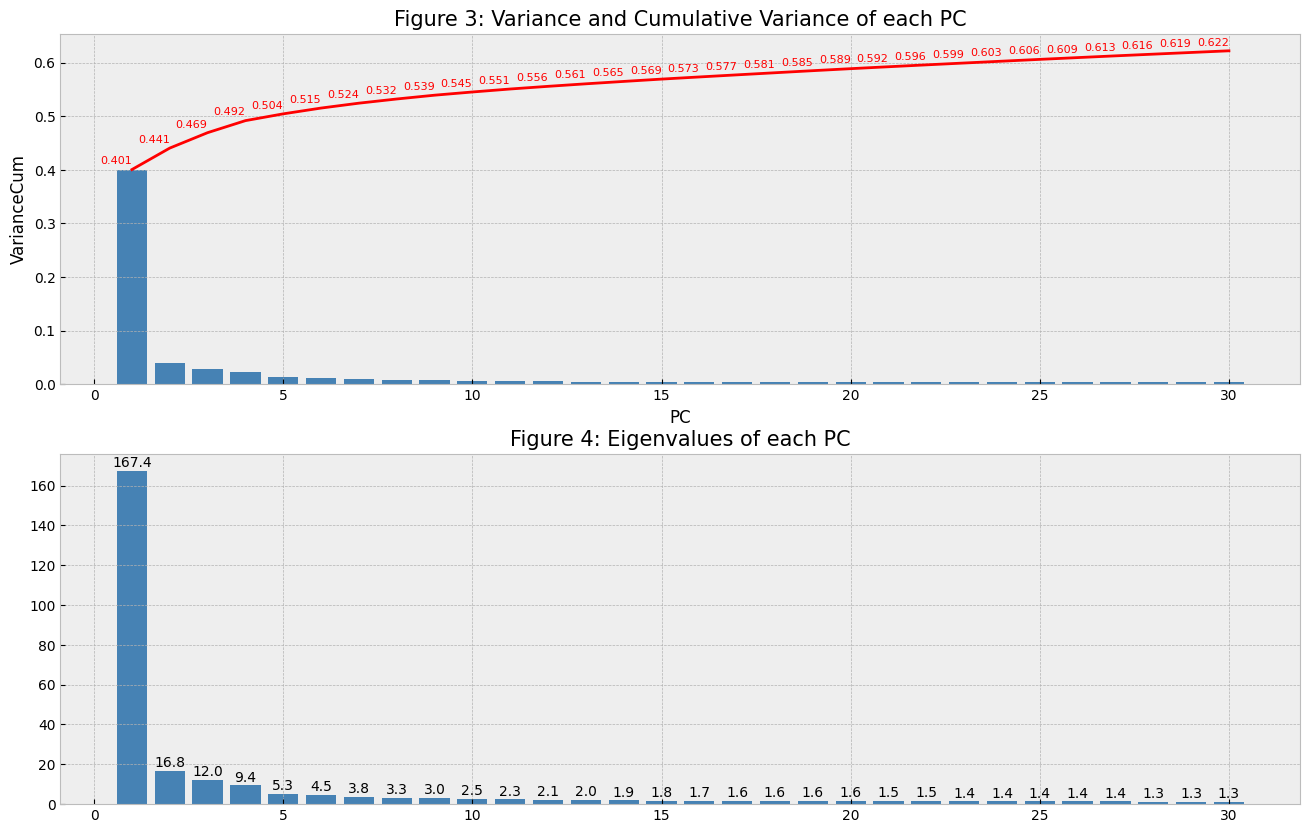

In [4]:
summary30 = pd.DataFrame({'Variance' : pca.explained_variance_ratio_[0:30],
                          'VarianceCum' : pca.explained_variance_ratio_[0:30].cumsum(),
                          'Eigenvalue' : pca.explained_variance_[0:30],
                          'PC' : np.arange(1, len(pca.explained_variance_ratio_[0:30])+1)})

plt.style.use('bmh')
plt.figure(num = 3, figsize=(16,10))

plt.subplot(211)
plt.bar(data = summary30,
         height = 'Variance', x = 'PC', color="steelblue")
sns.lineplot(data = summary30,
         y = 'VarianceCum', x = 'PC', color="red")
for i, v in enumerate(round(summary30.VarianceCum,3)):
    plt.text(summary30.PC.tolist()[i], v+0.01, str(v), ha='right', 
             fontsize=8, color = 'red')
plt.title('Figure 3: Variance and Cumulative Variance of each PC', size=15)

plt.subplot(212)
plt.figure(num = 3, figsize=(16,10))
plt.bar(data = summary30,
         height = 'Eigenvalue', x = 'PC', color="steelblue")
for i, v in enumerate(round(summary30.Eigenvalue,1)):
    plt.text(summary30.PC.tolist()[i], v+2, str(v), ha='center', 
             fontsize=10, color = 'black')
plt.title('Figure 4: Eigenvalues of each PC', size=15)
plt.show()



**3. Validation of interpretations**

In [5]:
#Calculation of first eigenportfolio returns

weights_first = eigenvectors[0]/np.sum(eigenvectors[0]) #Weights of the first PC

ret_portfolio_train = weights_first @ ret_sp500_norm_train.T #Portfolio returns

### 5- RESULTS

Correlation between first eigenportfoli an dmarket index

In [6]:
first_index_corr = np.corrcoef(ret_portfolio_train, ret_index_norm_train['SPX'])[0,1] #Correlation between portfolio and index returns

print(f'Correlation between first eigenportfolio and index returns: {first_index_corr:.3f}')

Correlation between first eigenportfolio and index returns: 0.987


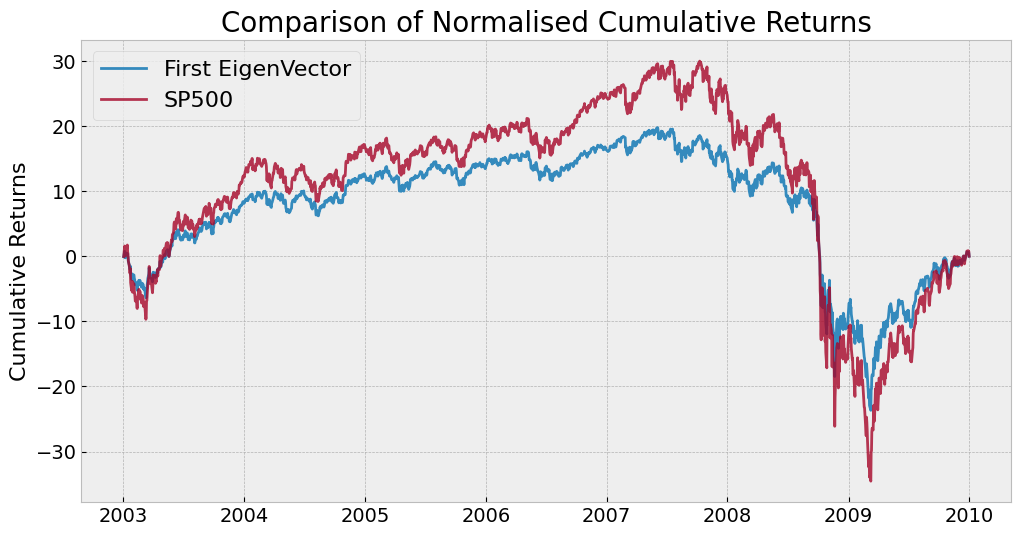

In [7]:
plt.style.use('bmh')  # Usando un estilo limpio y profesional

fig, ax = plt.subplots(figsize=(12, 6))  # Tamaño adecuado para inclusión en documentos

# Gráfico de la suma acumulada de retornos de la cartera
ax.plot(ret_portfolio_train.cumsum(), label='First EigenVector', linewidth=2)

# Gráfico de la suma acumulada de ret del índice normalizado
ax.plot(ret_index_norm_train.cumsum(), label='SP500', linewidth=2, alpha=0.8)

ax.set_title('Comparison of Normalised Cumulative Returns', fontsize=20)  # Título descriptivo
#ax.set_xlabel('Tiempo', fontsize=12)  # Etiqueta para el eje X
ax.set_ylabel('Cumulative Returns', fontsize=16)  # Etiqueta para el eje Y
ax.legend(fontsize=16)  # Leyenda con tamaño adecuado

ax.tick_params(labelsize=14)  # Adjust font size for tick labels

plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Guardar la figura en formato PDF para mejor calidad en LaTeX
plt.savefig('/workspace/imgs/retornos_acumulados.pdf', format='pdf', dpi=300)


plt.show()

In [8]:
X = ret_index_norm_train #Independent variable eigenportfolio returns
y = ret_portfolio_train #Dependent variable index returns
X_sm = sm.add_constant(X) #Adding constant to the model

model = sm.OLS(y, X_sm).fit() #Fitting the model

p_value_beta = model.pvalues.iloc[1] #P-value of beta coefficient

beta = model.params.iloc[1] #Beta coefficient

print(f'Beta between First Eigenportfolio and index market is: {beta:.2f}')
print(f'P-value: {p_value_beta:.4f}')

Beta between First Eigenportfolio and index market is: 0.63
P-value: 0.0000


In [9]:
print(f' First eigenportfolio variance is {ret_portfolio_train.var():.3f}')

 First eigenportfolio variance is 0.409


In [10]:
print(f' First eigenvalue is {pca.explained_variance_ratio_[0]:.3f}')

 First eigenvalue is 0.401


In [11]:
def calc_regresion(r_ind, r):
    '''
    Function to calculate the betas of the assets in the portfolio
    Parameters:
    r_ind: DataFrame with the index returns
    r: DataFrame with assets returns
    
    Returns:
    betas_df: DataFrame with the betas of the assets
    beta_no_sig: List with the assets with no significant beta  
    '''

    beta_no_sig = []
    beta_lst= []
    
    for activo in r.columns:
        X = r_ind
        y = r[activo]
        X_sm = sm.add_constant(X)
        
        modelo = sm.OLS(y, X_sm).fit()
        
        p_value_beta = modelo.pvalues.iloc[1]
        
        if p_value_beta > 0.05:
            beta_no_sig.append(activo)
        
        beta_lst.append(modelo.params.iloc[1])
        
    betas_df = pd.DataFrame(beta_lst, index = r.columns, columns = ['Beta'])
          
    return betas_df, beta_no_sig

In [12]:
# Obtén los nombres de los tickers del DataFrame original
tickers = ret_sp500_norm_train.columns

# Crea un DataFrame para visualizar los tickers y sus respectivos pesos en el primer componente principal
weights_first_df = pd.DataFrame(weights_first, index=tickers, columns=['Peso'])

# Calcula las varianzas de los retornos de los tickers
varianzas = ret_sp500_train.var()
# Crea un DataFrame a partir de las varianzas
varianzas_df = pd.DataFrame(varianzas, columns=['Varianza'])

In [13]:
betas, betas_no_significativos = calc_regresion(ret_index_train, ret_sp500_train)

In [14]:
betas_ordenadas_df = betas.sort_values(by='Beta', ascending=True)

# Añade los pesos y las varianzas a la tabla de betas
betas_ordenadas_df = betas_ordenadas_df.join(weights_first_df['Peso'])
betas_ordenadas_df = betas_ordenadas_df.join(varianzas_df['Varianza'])

In [15]:
# Datos
x = np.arange(len(betas_ordenadas_df))  # Esto asume que los datos están en orden secuencial
y = betas_ordenadas_df['Peso'].values

# Ajustar una línea recta
coeficientes = np.polyfit(x, y, 1)  # '1' significa una regresión lineal
polinomio_pesos = np.poly1d(coeficientes)

# Generar valores y para la línea de tendencia
y_tendencia_pesos = polinomio_pesos(x)

In [16]:
# Datos
x = np.arange(len(betas_ordenadas_df))  # Esto asume que los datos están en orden secuencial
y_var = betas_ordenadas_df['Varianza'].values

# Ajustar una línea recta
coeficientes_var = np.polyfit(x, y_var, 1)  # '1' significa una regresión lineal
polinomio_var = np.poly1d(coeficientes_var)

# Generar valores y para la línea de tendencia
y_tendencia_var = polinomio_var(x)

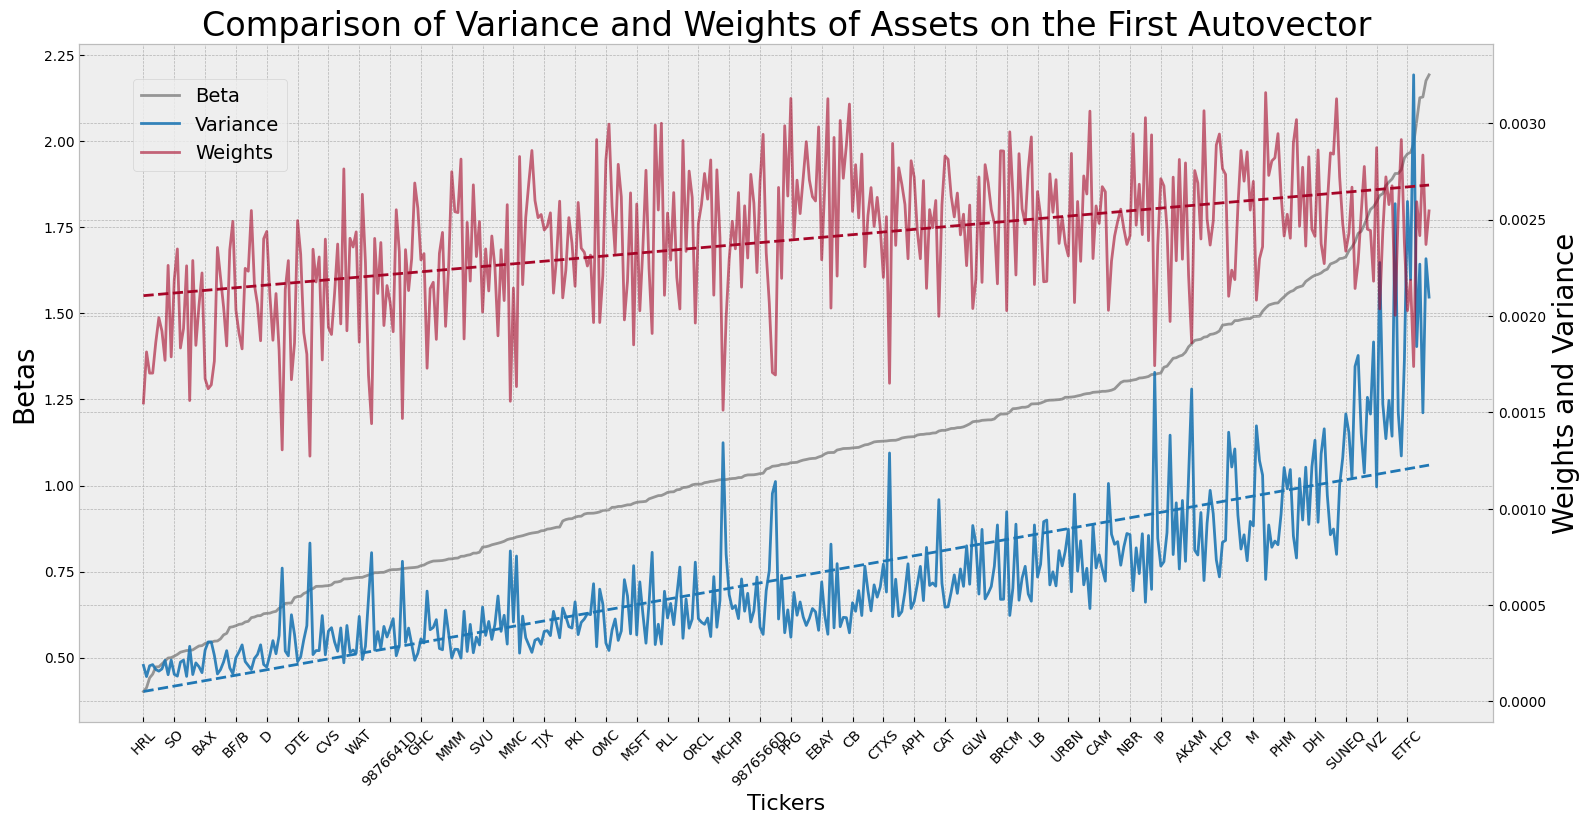

In [17]:
plt.style.use('bmh')  # Usando un estilo limpio y profesional

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Graficar la primera columna 'Varianza' en el eje y primario
color = 'tab:grey'
ax1.set_ylabel('Betas', color='black', fontsize=20)  # we already handled the x-label with ax1
ax1.set_xlabel('Tickers', color='black', fontsize=16)  # we already handled the x-label with ax1
ax1.plot(betas_ordenadas_df.index, betas_ordenadas_df['Beta'], color=color, alpha=0.8, label='Beta')

#ax1.plot(betas_ordenadas_df.index, y_tendencia, color=color, linestyle='--')  # Línea de tendencia

ax1.tick_params(axis='y', labelcolor='black')
tickers = betas_ordenadas_df.index.tolist()


# Establecer los xticks para que solo se muestre uno de cada 10
ax1.set_xticks(np.arange(0, len(tickers), 10))  # Establece las posiciones de los xticks cada 10 índices
ax1.set_xticklabels(tickers[::10], rotation=45)  # Establece las etiquetas de los xticks con una rotación de 45 grados



# Crear un segundo eje y que comparte el mismo eje x
ax2 = ax1.twinx()  # Instante de un segundo eje que comparte el eje x
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color, fontsize=20)  # we already handled the x-label with ax1

# Graficar la segunda columna 'Varianza' en el eje y secundario
ax2.plot(betas_ordenadas_df.index, betas_ordenadas_df['Varianza'], color=color, alpha=0.9, label='Variance')
ax2.plot(betas_ordenadas_df.index, y_tendencia_var, color=color, linestyle='--')  # Línea de tendencia
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('Weights and Variance', color='black', fontsize=20)  # we already handled the x-label with ax1
ax2.plot(betas_ordenadas_df.index, betas_ordenadas_df['Peso'], color='#A60628', alpha=0.6, label='Weights')
ax2.plot(betas_ordenadas_df.index, y_tendencia_pesos, color='#A60628', linestyle='--')  # Línea de tendencia


# Extraer handles y labels de ambos ejes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combinar handles y labels
handles = handles1 + handles2
labels = labels1 + labels2

# Crear una leyenda combinada
fig.legend(handles, labels, loc='upper left', fontsize=14, bbox_to_anchor=(0.08, 0.95))

# Título y ajustes finales
fig.tight_layout()  # Para asegurarse de que no hay solapamiento en la visualización
plt.title('Comparison of Variance and Weights of Assets on the First Autovector', fontsize=24)

# Guardar la figura en formato PDF para mejor calidad en LaTeX
plt.savefig('/workspace/imgs/pesos-variance.pdf', format='pdf', dpi=300)

plt.show()

In [18]:
# Definir el número de activos y el número de retornos
num_activos = 500
num_retorno = 5000

# Generar los retornos usando una distribución normal estándar
# La media es 0 y la desviación estándar es 1 por defecto
retornos_ind = np.random.normal(0, 1, (num_retorno, num_activos))


In [19]:
pca_ind = PCA() #Creating PCA object

pca_ind.fit(retornos_ind) #Fitting PCA object to the data

eigenvectors_ind = pca_ind.components_ #Principal components
eigenvalues_ind = pca_ind.explained_variance_ratio_ #Explained variance

In [20]:
cond_number_ind = eigenvalues_ind[0]/eigenvalues_ind[-1]

cond_numbar_train = eigenvalues[0]/eigenvalues[-1]

In [21]:
cond_numbar_train = eigenvalues[0]/eigenvalues[-1]


In [22]:
prices_index_bear = prices_sp500[['SPX']].loc['2008-5':'2009-3']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


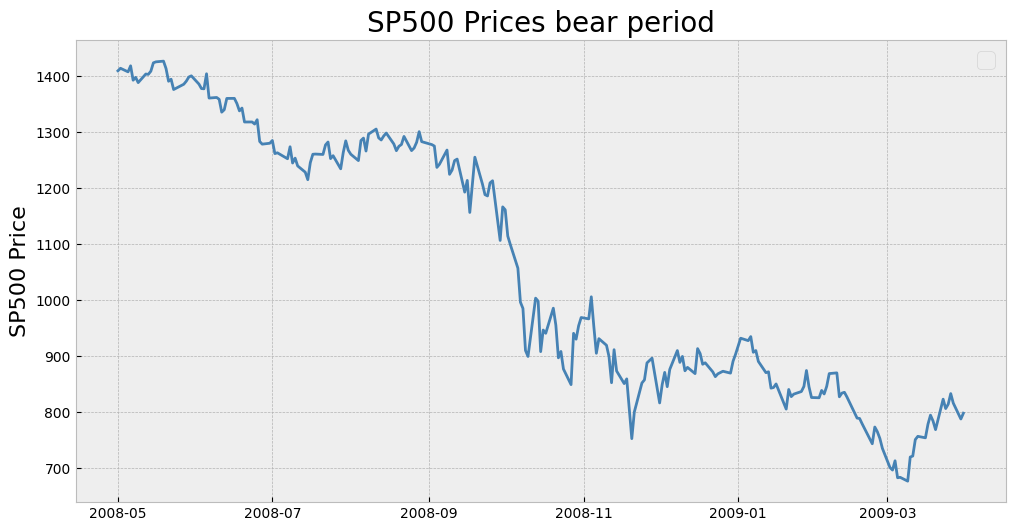

In [23]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar los datos antes y después de la fecha de corte con diferentes colores
ax.plot(prices_index_bear.index, prices_index_bear, color='#4682B4')

# Añadir título y etiquetas
ax.set_title('SP500 Prices bear period', fontsize=20)
ax.set_ylabel('SP500 Price', fontsize=16)
ax.legend(fontsize=16)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(labelsize=10)
plt.grid(True)

plt.savefig('/workspace/imgs/SP500_prices_bear.pdf')

# Mostrar la gráfica
plt.show()

In [24]:
ret_sp500_bear = ret_sp500.loc['2008-5':'2009-3']
ret_sp500_norm_bear = (ret_sp500_bear - ret_sp500_bear.mean())/ret_sp500_bear.std()

In [25]:
pca_bear = PCA() #Creating PCA object

pca_bear.fit(ret_sp500_norm_bear) #Fitting PCA object to the data

eigenvectors_bear = pca_bear.components_ #Principal components
eigenvalues_bear = pca_bear.explained_variance_ratio_ #Explained variance

In [26]:
cond_number_bear = eigenvalues_bear[0]/eigenvalues_bear[-1]

In [27]:
print(f'Condition number of independent returns: {cond_number_ind:.2f}')
print(f'Condition number of training returns: {cond_numbar_train:.2f}')
print(f'Condition number of bear returns: {cond_number_bear:.2f}')

Condition number of independent returns: 3.64
Condition number of training returns: 3426525.11
Condition number of bear returns: 5070602401397804415267098329088.00


In [28]:
# Calculation of second and third eigenportfolio returns
weights_second = eigenvectors[1]/np.sum(eigenvectors[1])
weights_second_df = pd.DataFrame(weights_second, index=tickers, columns=['Peso'])
weights_second_ord_df = weights_second_df.sort_values(by='Peso', ascending=False)

weights_third = eigenvectors[2]/np.sum(eigenvectors[2])
weights_third_df = pd.DataFrame(weights_third, index=tickers, columns=['Peso'])
weights_third_ord_df = weights_third_df.sort_values(by='Peso', ascending=False)

In [29]:
ret_port_train_first = weights_first @ ret_sp500_norm_train.T

ret_port_train_second = weights_second @ ret_sp500_norm_train.T

ret_port_train_third = weights_third @ ret_sp500_norm_train.T

In [30]:
print(f'Correlation between first and second eigenportfolios: {np.corrcoef(ret_port_train_first, ret_port_train_second)[0,1]:.2e}') 
print(f'Correlation between first and third eigenportfolios: {np.corrcoef(ret_port_train_first, ret_port_train_third)[0,1]:.3e}')
print(f'Correlation between second and third eigenportfolios: {np.corrcoef(ret_port_train_second, ret_port_train_third)[0,1]:.3e}')

Correlation between first and second eigenportfolios: -2.91e-14
Correlation between first and third eigenportfolios: -8.649e-16
Correlation between second and third eigenportfolios: 6.949e-17


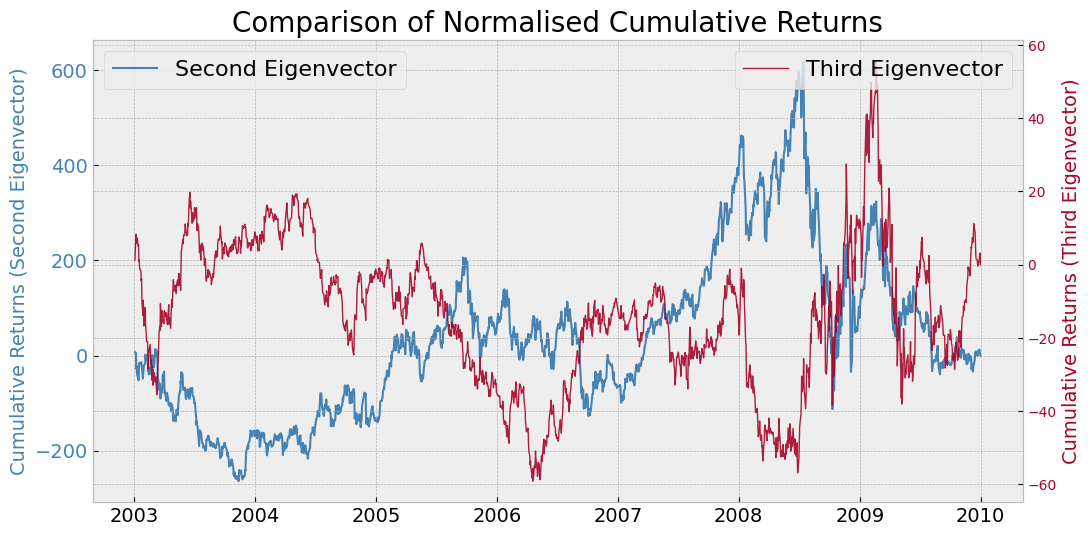

In [31]:
plt.style.use('bmh')  # Usando un estilo limpio y profesional

fig, ax1 = plt.subplots(figsize=(12, 6))  # Tamaño adecuado para inclusión en documentos

# Gráfico de la suma acumulada de retornos de la primera cartera
# ax1.plot(ret_cartera_train.cumsum(), label='Second Eigenvector', linewidth=2, color='b')

# ax1.plot(ret_cartera_train.cumsum().rolling(200).mean(), linestyle='--', linewidth=1, alpha=0.8, color='b')
ax1.set_ylabel('Cumulative Returns (Second Eigenvector)', fontsize=14, color='#4682B4')  # Etiqueta para el eje Y
ax1.tick_params(axis='y', labelcolor='#4682B4')  # Color del eje y

# Gráfico de la suma acumulada de retornos de la segunda cartera (índice normalizado)
ax1.plot(ret_port_train_second.cumsum(), label='Second Eigenvector', linewidth=1.5, color='#4682B4')
#ax1.plot(ret_cartera_train_segundo.cumsum().rolling(200).mean(), linestyle='--', linewidth=1, alpha=0.8, color='b')

# Crear un segundo eje y
ax2 = ax1.twinx()



ax2.set_ylabel('Cumulative Returns (Third Eigenvector)', fontsize=16, color='#A60628')  # Etiqueta para el segundo eje Y
ax2.tick_params(axis='y', labelcolor='#A60628')  # Color del eje y

ax2.plot(ret_port_train_third.cumsum(), label='Third Eigenvector', linewidth=1, alpha=0.9, color='#A60628')
#ax2.plot(ret_cartera_train_tercer.cumsum().rolling(200).mean(), linestyle='--', linewidth=1, alpha=0.8, color='#A60628')

ax2.set_ylabel('Cumulative Returns (Third Eigenvector)', fontsize=14, color='#A60628')  # Etiqueta para el segundo eje Y
ax2.tick_params(axis='y', labelcolor='#A60628')  # Color del eje y

ax1.set_title('Comparison of Normalised Cumulative Returns', fontsize=20)  # Título descriptivo

ax1.legend(loc='upper left', fontsize=16)  # Leyenda para el primer eje y
ax2.legend(loc='upper right', fontsize=16)  # Leyenda para el segundo eje y

ax1.tick_params(labelsize=14)  # Ajustar tamaño de fuente para las etiquetas de los ticks

plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Guardar la figura en formato PDF para mejor calidad en LaTeX
plt.savefig('/workspace/imgs/retornos_acumulados23_train.pdf', format='pdf', dpi=300)

plt.show()

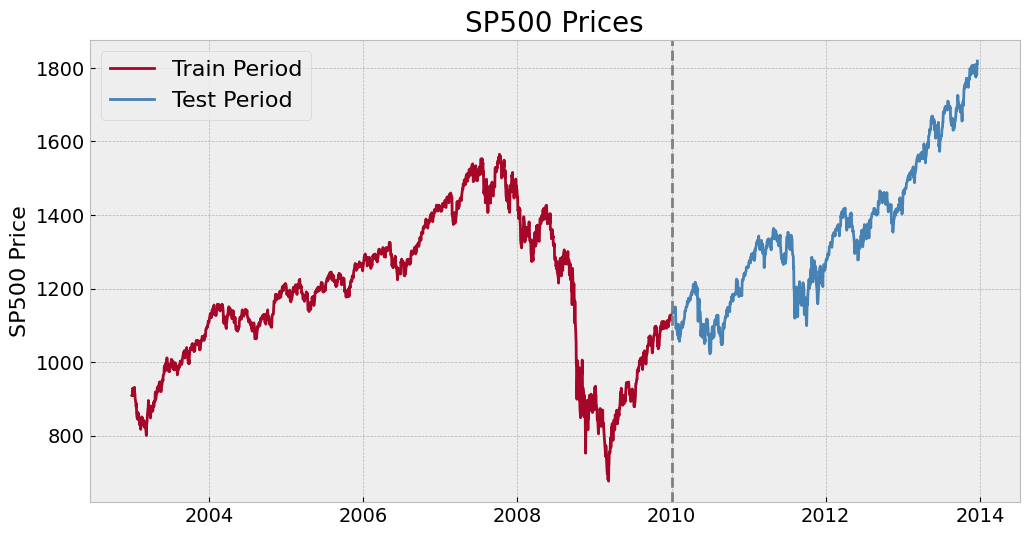

In [32]:
# Fecha de corte
train_end = '2010-01-01'

# Separar los datos antes y después de la fecha de corte usando .loc
prices_before = prices_sp500.loc[:train_end]
prices_after = prices_sp500.loc[train_end:]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar los datos antes y después de la fecha de corte con diferentes colores
ax.plot(prices_before.index, prices_before['SPX'], label='Train Period', color='#A60628')
ax.plot(prices_after.index, prices_after['SPX'], label='Test Period', color='#4682B4')
ax.axvline(pd.to_datetime(train_end), linestyle='--', color='gray')

# Añadir título y etiquetas
ax.set_title('SP500 Prices', fontsize=20)
ax.set_ylabel('SP500 Price', fontsize=16)
ax.legend(fontsize=16)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(labelsize=14)
plt.grid(True)

plt.savefig('/workspace/imgs/SP500_prices.pdf')

# Mostrar la gráfica
plt.show()

In [33]:
pca_test = PCA()

pca_test.fit(ret_sp500_norm_test)

autovectores_test = pca_test.components_
autovalores_test = pca_test.explained_variance_ratio_


pesos_primer_test = autovectores_test[0]/np.sum(autovectores_test[0])

ret_cartera_test = pesos_primer_test @ ret_sp500_norm_test.T

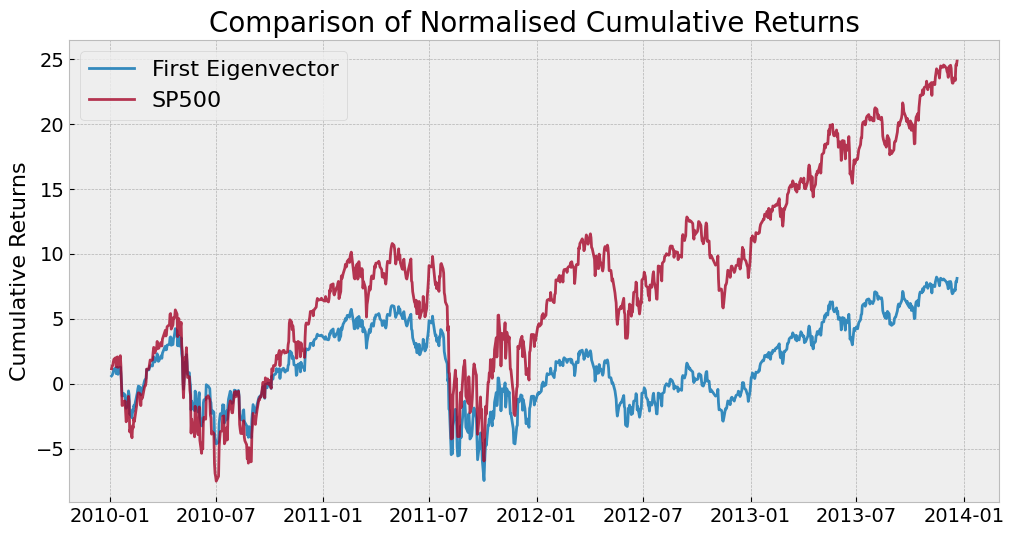

In [34]:
plt.style.use('bmh')  # Usando un estilo limpio y profesional

fig, ax = plt.subplots(figsize=(12, 6))  # Tamaño adecuado para inclusión en documentos

# Gráfico de la suma acumulada de retornos de la cartera
ax.plot(ret_cartera_test.cumsum(), label='First Eigenvector', linewidth=2)

# Gráfico de la suma acumulada de ret del índice normalizado
ax.plot(ret_index_norm_test.cumsum(), label='SP500', linewidth=2, alpha=0.8)

ax.set_title('Comparison of Normalised Cumulative Returns', fontsize=20)  # Título descriptivo
#ax.set_xlabel('Tiempo', fontsize=12)  # Etiqueta para el eje X
ax.set_ylabel('Cumulative Returns', fontsize=16)  # Etiqueta para el eje Y
ax.legend(fontsize=16)  # Leyenda con tamaño adecuado

ax.tick_params(labelsize=14)  # Adjust font size for tick labels

plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Guardar la figura en formato PDF para mejor calidad en LaTeX
plt.savefig('/workspace/imgs/retornos_acumulados_test.pdf', format='pdf', dpi=300)


plt.show()

In [35]:
ret_port_test_second = weights_second @ ret_sp500_norm_test.T

ret_port_test_third = weights_third @ ret_sp500_norm_test.T

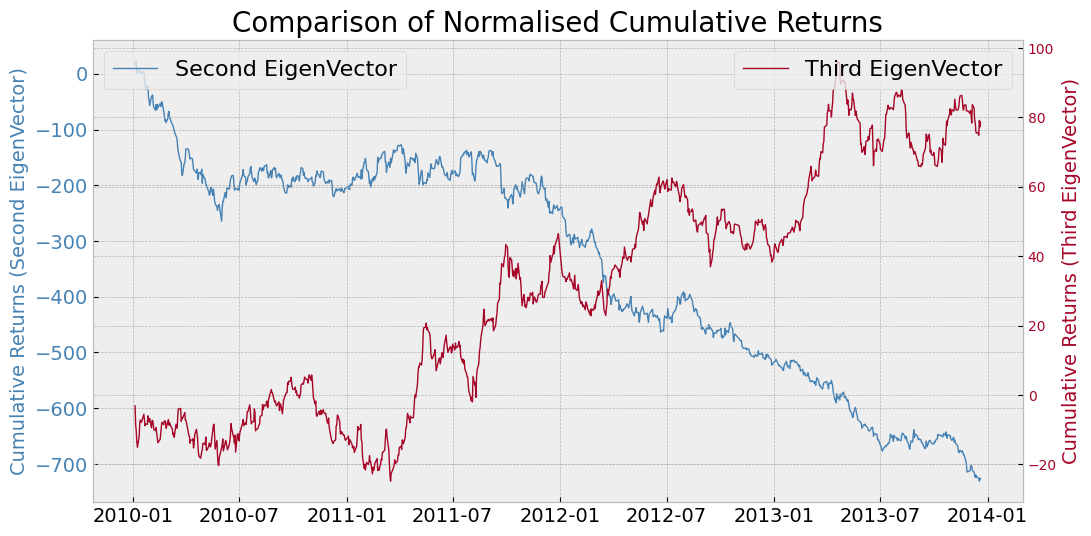

In [36]:
plt.style.use('bmh')  # Usando un estilo limpio y profesional

import matplotlib.pyplot as plt

plt.style.use('bmh')  # Usando un estilo limpio y profesional

fig, ax1 = plt.subplots(figsize=(12, 6))  # Tamaño adecuado para inclusión en documentos

# Gráfico de la suma acumulada de retornos de la primera cartera
# ax1.plot(ret_cartera_train.cumsum(), label='Second Autovector', linewidth=2, color='b')

# ax1.plot(ret_cartera_train.cumsum().rolling(200).mean(), linestyle='--', linewidth=1, alpha=0.8, color='b')
ax1.set_ylabel('Cumulative Returns (Second EigenVector)', fontsize=14, color='#4682B4')  # Etiqueta para el eje Y
ax1.tick_params(axis='y', labelcolor='#4682B4')  # Color del eje y

# Gráfico de la suma acumulada de retornos de la segunda cartera (índice normalizado)
ax1.plot(ret_port_test_second.cumsum(), label='Second EigenVector', linewidth=1, alpha=1, color='#4682B4')
#ax1.plot(ret_cartera_train_segundo.cumsum().rolling(200).mean(), linestyle='--', linewidth=1, alpha=0.8, color='b')

# Crear un segundo eje y
ax2 = ax1.twinx()



ax2.set_ylabel('Cumulative Returns (Third EigenVector)', fontsize=16, color='r')  # Etiqueta para el segundo eje Y
ax2.tick_params(axis='y', labelcolor='r')  # Color del eje y

ax2.plot(ret_port_test_third.cumsum(), label='Third EigenVector', linewidth=1, alpha=1, color='#A60628')
#ax2.plot(ret_cartera_train_tercer.cumsum().rolling(200).mean(), linestyle='--', linewidth=1, alpha=0.8, color='#A60628')

ax2.set_ylabel('Cumulative Returns (Third EigenVector)', fontsize=14, color='#A60628')  # Etiqueta para el segundo eje Y
ax2.tick_params(axis='y', labelcolor='#A60628')  # Color del eje y

ax1.set_title('Comparison of Normalised Cumulative Returns', fontsize=20)  # Título descriptivo

ax1.legend(loc='upper left', fontsize=16)  # Leyenda para el primer eje y
ax2.legend(loc='upper right', fontsize=16)  # Leyenda para el segundo eje y

ax1.tick_params(labelsize=14)  # Ajustar tamaño de fuente para las etiquetas de los ticks

plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Guardar la figura en formato PDF para mejor calidad en LaTeX
plt.savefig('/workspace/imgs/retornos_acumulados23_test.pdf', format='pdf', dpi=300)

plt.show()

----